In [3]:
import pandas as pd
import os
from skimpy import skim
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def read_ratings(ratings_csv: str, data_dir: str = "/home/antoine/Ml_Ops_Movies_Reco/src/data/data/raw") -> pd.DataFrame:
    """
    Lit le fichier CSV contenant les √©valuations des films.

    :param ratings_csv: Nom du fichier CSV contenant les √©valuations.
    :param data_dir: R√©pertoire o√π se trouve le fichier CSV.
    :return: DataFrame contenant les √©valuations.
    """
    data = pd.read_csv(os.path.join(data_dir, ratings_csv))
    print("Dataset ratings charg√©")
    return data

def read_movies(movies_csv: str, data_dir: str = "/home/antoine/Ml_Ops_Movies_Reco/src/data/data/raw") -> pd.DataFrame:
    """
    Lit le fichier CSV contenant les informations sur les films.

    :param movies_csv: Nom du fichier CSV contenant les informations sur les films.
    :param data_dir: R√©pertoire o√π se trouve le fichier CSV.
    :return: DataFrame contenant les informations sur les films.
    """
    df = pd.read_csv(os.path.join(data_dir, movies_csv))
    print("Dataset movies charg√©")
    return df

L'ensemble de donn√©es des films doit √™tre nettoy√© de deux mani√®res¬†:
- les genres sont exprim√©s sous forme de cha√Æne avec un pipe
- le titre contient actuellement (ann√©e) ajout√© √† la fin. Nous allons extraire l'ann√©e de chaque cha√Æne de titre et cr√©er une nouvelle colonne pour celle-ci.

In [5]:
movies = read_movies('movies.csv')
# Split sur les pipes
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

Dataset movies charg√©


movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                              genres  
0  [Adventure, Animation, Children, Comedy, Fantasy]  
1                     [Adventure, Children, Fantasy]  
2                                  [Comedy, Romance]  
3                           [Comedy, Drama, Romance]  
4                                           [Comedy]

In [4]:
# Calcul du nombre de genres
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"Il y a  {len(genre_frequency)} genres.")

genre_frequency

Il y a  20 genres.


Counter({'Drama': 13344,
         'Comedy': 8374,
         'Thriller': 4178,
         'Romance': 4127,
         'Action': 3520,
         'Crime': 2939,
         'Horror': 2611,
         'Documentary': 2471,
         'Adventure': 2329,
         'Sci-Fi': 1743,
         'Mystery': 1514,
         'Fantasy': 1412,
         'War': 1194,
         'Children': 1139,
         'Musical': 1036,
         'Animation': 1027,
         'Western': 676,
         'Film-Noir': 330,
         '(no genres listed)': 246,
         'IMAX': 196})

In [5]:
# Genres les plus repr√©sent√©s:
print("Les 5 genres les plus repr√©sent√©s sont : \n", genre_frequency.most_common(5))

Les 5 genres les plus repr√©sent√©s sont : 
 [('Drama', 13344), ('Comedy', 8374), ('Thriller', 4178), ('Romance', 4127), ('Action', 3520)]


/tmp/ipykernel_26525/3865811001.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False), palette='viridis')


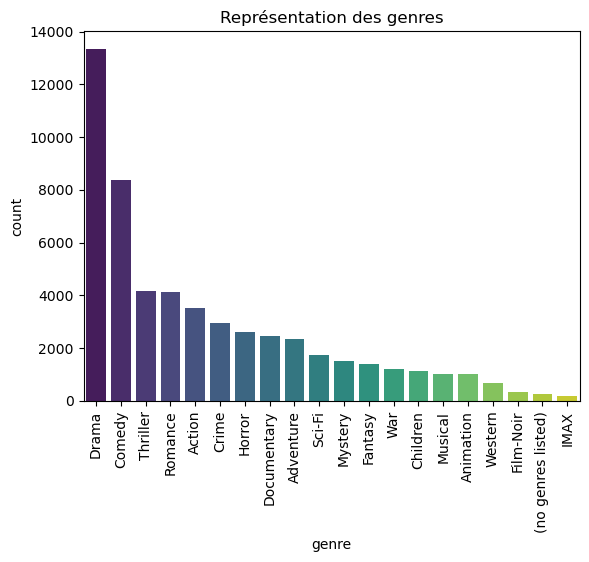

In [7]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False), palette='viridis')
plt.xticks(rotation=90)
plt.title("Repr√©sentation des genres")
plt.show()

Nous allons utiliser une technique appel√©e filtrage collaboratif pour g√©n√©rer des recommandations pour les utilisateurs. Cette technique repose sur le principe selon lequel des personnes similaires aiment des choses similaires. La premi√®re √©tape consiste √† transformer nos donn√©es en une matrice utilisateur-√©l√©ment, √©galement appel√©e matrice ¬´ utilitaire ¬ª. Dans cette matrice, les lignes repr√©sentent les utilisateurs et les colonnes repr√©sentent les films. L'avantage du filtrage collaboratif est qu'il ne n√©cessite aucune information sur les utilisateurs ou sur l'utilisateur des films pour g√©n√©rer des recommandations.

Nous cr√©ons une fonction create_X() qui g√©n√®re une matrice creuse avec quatre dictionnaires de mappage¬†:

- user_mapper¬†: mappe l'ID utilisateur √† l'index utilisateur
- movie_mapper¬†: mappe l'ID du film √† l'index du film
- user_inv_mapper¬†: mappe l'index utilisateur √† l'ID utilisateur
- movie_inv_mapper¬†: mappe l'index du film √† l'ID du film

Nous avons besoin de ces dictionnaires car ils mappent quelle ligne/colonne de la matrice utilitaire correspond √† quel ID utilisateur/film.

In [6]:
from scipy.sparse import csr_matrix
from scipy import sparse

def create_X(df):
    """
    G√©n√®re une matrice creuse avec quatre dictionnaires de mappage
    - user_mapper: mappe l'ID utilisateur √† l'index utilisateur
    - movie_mapper: mappe l'ID du film √† l'index du film
    - user_inv_mapper: mappe l'index utilisateur √† l'ID utilisateur
    - movie_inv_mapper: mappe l'index du film √† l'ID du film
    Args:
        df: pandas dataframe contenant 3 colonnes (userId, movieId, rating)

    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))

    # Sauvegarder la matrice creuse dans un fichier
    sparse.save_npz('sparse_matrix.npz', X)

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper


In [7]:
ratings = read_ratings('ratings.csv')

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

Dataset ratings charg√©


In [23]:
# Afficher la forme de la matrice creuse
print("Shape de la matrice creuse X :", X.shape)

# Afficher quelques √©l√©ments non nuls de la matrice
print("\n√âl√©ments non nuls dans la matrice creuse :")
print(X.nonzero())  # Affiche les indices des √©l√©ments non nuls
print(X.data[:10])  # Affiche les 10 premi√®res notes

Shape de la matrice creuse X : (138493, 26744)

√âl√©ments non nuls dans la matrice creuse :
(array([     0,      0,      0, ..., 138492, 138492, 138492], dtype=int32), array([    1,    28,    31, ..., 13875, 13993, 14277], dtype=int32))
[3.5 3.5 3.5 3.5 3.5 3.5 4.  4.  4.  4. ]


In [24]:
# Afficher un aper√ßu des mappers
print("\nAper√ßu du user_mapper (premiers 5 utilisateurs) :")
for user_id, index in list(user_mapper.items())[:5]:
    print(f"User ID: {user_id} -> Index: {index}")

print("\nAper√ßu du movie_mapper (premiers 5 films) :")
for movie_id, index in list(movie_mapper.items())[:5]:
    print(f"Movie ID: {movie_id} -> Index: {index}")

print("\nAper√ßu du user_inv_mapper (premiers 5 indices utilisateurs) :")
for index, user_id in list(user_inv_mapper.items())[:5]:
    print(f"Index: {index} -> User ID: {user_id}")

print("\nAper√ßu du movie_inv_mapper (premiers 5 indices films) :")
for index, movie_id in list(movie_inv_mapper.items())[:5]:
    print(f"Index: {index} -> Movie ID: {movie_id}")


Aper√ßu du user_mapper (premiers 5 utilisateurs) :
User ID: 1 -> Index: 0
User ID: 2 -> Index: 1
User ID: 3 -> Index: 2
User ID: 4 -> Index: 3
User ID: 5 -> Index: 4

Aper√ßu du movie_mapper (premiers 5 films) :
Movie ID: 1 -> Index: 0
Movie ID: 2 -> Index: 1
Movie ID: 3 -> Index: 2
Movie ID: 4 -> Index: 3
Movie ID: 5 -> Index: 4

Aper√ßu du user_inv_mapper (premiers 5 indices utilisateurs) :
Index: 0 -> User ID: 1
Index: 1 -> User ID: 2
Index: 2 -> User ID: 3
Index: 3 -> User ID: 4
Index: 4 -> User ID: 5

Aper√ßu du movie_inv_mapper (premiers 5 indices films) :
Index: 0 -> Movie ID: 1
Index: 1 -> Movie ID: 2
Index: 2 -> Movie ID: 3
Index: 3 -> Movie ID: 4
Index: 4 -> Movie ID: 5


Nous avons 138493 users et 26744 films

Esnuite, nous calculons la parcimonie en divisant le nombre d'√©l√©ments stock√©s par le nombre total d'√©l√©ments. Le nombre d'√©l√©ments stock√©s (non vides) dans notre matrice (nnz) est √©quivalent au nombre de notes dans notre ensemble de donn√©es.

In [12]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 0.54%


csr_matrix.nnz compte les valeurs stock√©es dans notre matrice. Le reste de nos cellules sont vides.

Le probl√®me de d√©marrage √† froid se produit lorsqu'il y a de nouveaux utilisateurs et films dans notre matrice qui n'ont aucune note. Dans notre ensemble de donn√©es, tous les utilisateurs et films ont au moins une note, mais il est utile de v√©rifier quels utilisateurs et films ont peu d'interactions.

In [13]:
n_ratings_per_user = X.getnnz(axis=1)
print(f"L'utilisateur le plus actif a not√© {n_ratings_per_user.max()} films.")
print(f"Le moins actif en a not√© {n_ratings_per_user.min()}")

L'utilisateur le plus actif a not√© 9254 films.
Le moins actif en a not√© 20


In [14]:
n_ratings_per_movie = X.getnnz(axis=0)
print(f"Le film le plus not√© a obtenu {n_ratings_per_movie.max()} vote.")
print(f"Le moins not√© en a obtenu {n_ratings_per_movie.min()}.")

Le film le plus not√© a obtenu 67310 vote.
Le moins not√© en a obtenu 1.


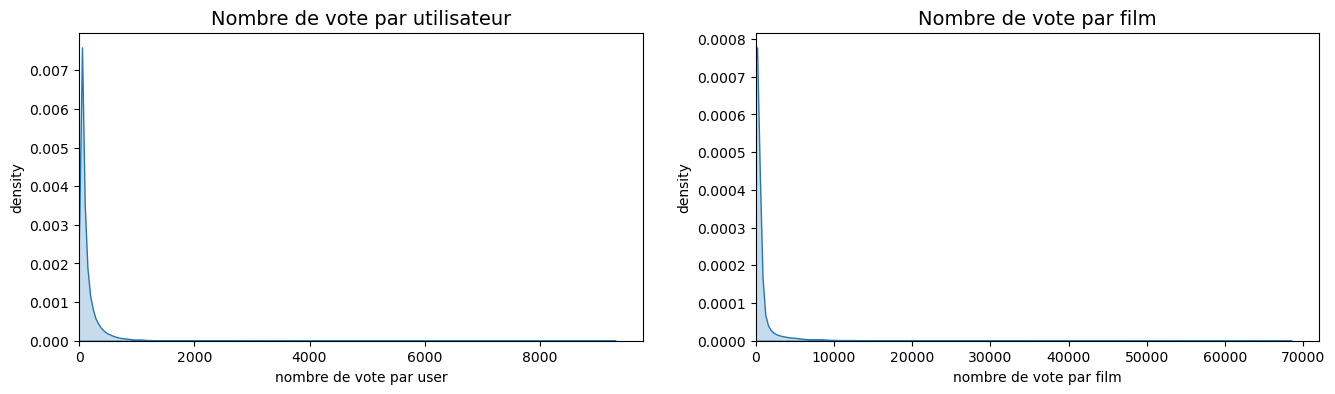

In [17]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, fill=True)
plt.xlim(0)
plt.title("Nombre de vote par utilisateur", fontsize=14)
plt.xlabel("nombre de vote par user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, fill=True)
plt.xlim(0)
plt.title("Nombre de vote par film", fontsize=14)
plt.xlabel("nombre de vote par film")
plt.ylabel("density")
plt.show();


### Recommendations avec KNN

Nous allons trouver les ùëò films qui ont les vecteurs d'engagement des utilisateurs les plus similaires pour un film donn√© .

In [8]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Trouve les k voisins les plus proches pour un ID de film donn√©.

    Args:
        movie_id: ID du film d'int√©r√™t
        X: matrice d'utilit√© utilisateur-article (matrice creuse)
        k: nombre de films similaires √† r√©cup√©rer
        metric: m√©trique de distance pour les calculs kNN

    Output: retourne une liste des k ID de films similaires
    """
    # Transposer la matrice X pour que les films soient en lignes et les utilisateurs en colonnes
    X = X.T
    neighbour_ids = []  # Liste pour stocker les ID des films similaires

    # Obtenir l'index du film √† partir du mapper
    movie_ind = movie_mapper[movie_id]

    # Extraire le vecteur correspondant au film sp√©cifi√©
    movie_vec = X[movie_ind]

    # V√©rifier si movie_vec est un tableau NumPy et le remodeler en 2D si n√©cessaire
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1, -1)  # Reshape pour avoir une forme (1, n_features)

    # Initialiser NearestNeighbors avec k+1 car nous voulons inclure le film lui-m√™me dans les voisins
    kNN = NearestNeighbors(n_neighbors=k + 1, algorithm="brute", metric=metric)

    # Ajuster le mod√®le sur la matrice transpos√©e (films comme lignes)
    kNN.fit(X)

    # Trouver les k+1 voisins les plus proches (y compris le film d'int√©r√™t)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)

    # Collecter les ID des films parmi les voisins trouv√©s
    for i in range(0, k):  # Boucler jusqu'√† k pour obtenir seulement les films similaires
        n = neighbour.item(i)  # Obtenir l'index du voisin
        neighbour_ids.append(movie_inv_mapper[n])  # Mapper l'index √† l'ID du film

    neighbour_ids.pop(0)  # Retirer le premier √©l√©ment qui est l'ID du film original

    return neighbour_ids  # Retourner la liste des ID de films similaires

In [34]:
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies

[260, 780, 1210, 3114, 1270, 356, 588, 648, 480]

In [35]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Star Wars: Episode IV - A New Hope (1977)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode VI - Return of the Jedi (1983)
Toy Story 2 (1999)
Back to the Future (1985)
Forrest Gump (1994)
Aladdin (1992)
Mission: Impossible (1996)
Jurassic Park (1993)


Les r√©sultats ci-dessus montrent les 10 films les plus similaires √† Toy Story. La plupart des films de cette liste sont des films familiaux des ann√©es 1990, ce qui d√©montre une certaine performance de notre mod√®le. Ces recommandations sont bas√©es uniquement sur les notes des utilisateurs. Les caract√©ristiques des films telles que les genres ne sont pas utilis√©es dans cette approche. Nous pouvons √©galement jouer avec la mesure de distance kNN et voir les r√©sultats obtenus en utilsant ¬´ Manhattan ¬ª ou ¬´ Euclidien ¬ª au lieu de ¬´ Cosinus ¬ª.

In [36]:
# metric Euclidiean
movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='euclidean', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Willy Wonka & the Chocolate Factory (1971)
Independence Day (a.k.a. ID4) (1996)
Mission: Impossible (1996)
Twister (1996)
Bug's Life, A (1998)
Men in Black (a.k.a. MIB) (1997)
Monsters, Inc. (2001)
Groundhog Day (1993)


In [37]:
# metric Manhattan
movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='manhattan', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Willy Wonka & the Chocolate Factory (1971)
Bug's Life, A (1998)
Monsters, Inc. (2001)
Mission: Impossible (1996)
Finding Nemo (2003)
Independence Day (a.k.a. ID4) (1996)
Twister (1996)
Men in Black (a.k.a. MIB) (1997)


### Probl√®me du "d√©marrage √† froid"

Le filtrage collaboratif repose uniquement sur les interactions utilisateur-√©l√©ment au sein de la matrice d'utilit√©. Le probl√®me avec cette approche est que les nouveaux utilisateurs ou les √©l√©ments sans it√©ration sont exclus du syst√®me de recommandation. C'est ce qu'on appelle le probl√®me du d√©marrage √† froid. Le filtrage bas√© sur le contenu est un moyen de g√©rer ce probl√®me en g√©n√©rant des recommandations bas√©es sur les caract√©ristiques de l'utilisateur et de l'√©l√©ment.

Tout d'abord, nous devons convertir la colonne des genres en caract√©ristiques binaires. Chaque genre aura sa propre colonne dans le dataframe et sera renseign√© avec 0 ou 1.

In [9]:
n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 27278 unique movies in our movies dataset.


In [10]:
genres = set(g for G in movies['genres'] for g in G)

for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))

movie_genres = movies.drop(columns=['movieId', 'title','genres'])

In [11]:
movie_genres.head()

Romance  Action  Documentary  Crime  Fantasy  Comedy  Western  Adventure  \
0        0       0            0      0        1       1        0          1   
1        0       0            0      0        1       0        0          1   
2        1       0            0      0        0       1        0          0   
3        1       0            0      0        0       1        0          0   
4        0       0            0      0        0       1        0          0   

   Mystery  Children  Film-Noir  IMAX  Horror  Thriller  Drama  \
0        0         1          0     0       0         0      0   
1        0         1          0     0       0         0      0   
2        0         0          0     0       0         0      0   
3        0         0          0     0       0         0      1   
4        0         0          0     0       0         0      0   

   (no genres listed)  Musical  War  Sci-Fi  Animation  
0                   0        0    0       0          1  
1                   0        0    0       0          0  
2                   0        0    0       0          0  
3                   0        0    0       0          0  
4                   0        0    0       0          0

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_genres, movie_genres)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (27278, 27278)


Comme pr√©vu, apr√®s avoir pass√© la trame de donn√©es movie_genres dans la fonction cosine_similarity(), nous obtenons une matrice de similarit√© cosinus de forme . Cette matrice est renseign√©e avec des valeurs comprises entre 0 et 1 qui repr√©sentent le degr√© de similarit√© entre les films le long des axes x et y.

### Creation d'un chercheur de films

Supposons que nous souhaitons obtenir des recommandations pour des films similaires √† Jumanji. Pour obtenir des r√©sultats de notre outil de recommandation, nous devons conna√Ætre le titre exact d'un film dans notre ensemble de donn√©es. Dans notre ensemble de donn√©es, Jumanji est en fait r√©pertori√© comme ¬´ Jumanji (1995) ¬ª. Si nous orthographions mal Jumanji ou oublions d'inclure son ann√©e de sortie, notre outil de recommandation ne pourra pas identifier le film qui nous int√©resse. Pour rendre notre outil de recommandation plus convivial, nous pouvons utiliser un package Python appel√© **fuzzywuzzy** qui trouvera le titre le plus similaire √† une cha√Æne que vous transmettez. Cr√©ons une fonction appel√©e movie_finder() qui tire parti de l'algorithme de correspondance de cha√Ænes de fuzzywuzzy pour obtenir le titre le plus similaire √† une cha√Æne saisie par l'utilisateur.

In [13]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

In [14]:
title = movie_finder('juminji')
title

'Jumanji (1995)'

Pour obtenir des recommandations pertinentes pour Jumanji, nous devons trouver son index dans la matrice de similitude cosinus. Pour identifier la ligne que nous devons examiner, nous pouvons cr√©er un mappeur d'index de film qui mappe un titre de film √† l'index qu'il repr√©sente dans notre matrice. Cr√©ons un dictionnaire d'index de film appel√© movie_idx o√π les cl√©s sont les titres de film et les valeurs sont les indices de film¬†:

In [15]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
print(f"Movie index for Jumanji: {idx}")

Movie index for Jumanji: 1


Gr√¢ce √† ce dictionnaire movie_idx pratique, nous savons que Jumanji est repr√©sent√© par l'index 1 dans notre matrice. Passons au top 10 des films les plus similaires √† Jumanji.

In [16]:
n_recommendations=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]

similar_movies est un tableau d'indices qui repr√©sente les 10 principales recommandations de Jumanji. Nous pouvons obtenir les titres de films correspondants soit en cr√©ant un mappeur movie_idx inverse, soit en utilisant iloc sur la colonne de titre de la trame de donn√©es des films.

In [17]:
print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]

Because you watched Jumanji (1995):


55                         Kids of the Round Table (1995)
59                     Indian in the Cupboard, The (1995)
124                     NeverEnding Story III, The (1994)
990                       Escape to Witch Mountain (1975)
1959            Darby O'Gill and the Little People (1959)
2009                                  Return to Oz (1985)
2077                        NeverEnding Story, The (1984)
2078    NeverEnding Story II: The Next Chapter, The (1...
2314                        Santa Claus: The Movie (1985)
4800    Harry Potter and the Sorcerer's Stone (a.k.a. ...
Name: title, dtype: object

In [18]:
# Focntion qui regroupe les recommandations
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Because you watched {title}:")
    print(movies['title'].iloc[similar_movies])

In [20]:
get_content_based_recommendations('toy story', 10)

Because you watched Toy Story (1995):
2209                                           Antz (1998)
3027                                    Toy Story 2 (1999)
3663        Adventures of Rocky and Bullwinkle, The (2000)
3922                      Emperor's New Groove, The (2000)
4790                                 Monsters, Inc. (2001)
10114    DuckTales: The Movie - Treasure of the Lost La...
10987                                     Wild, The (2006)
11871                               Shrek the Third (2007)
13337                       Tale of Despereaux, The (2008)
18274    Asterix and the Vikings (Ast√É¬©rix et les Vikin...
Name: title, dtype: object


### R√©duction de dimensionnalit√© avec factorisation matricielle

La factorisation matricielle (MF) est une technique d'alg√®bre lin√©aire qui peut nous aider √† d√©couvrir des caract√©ristiques latentes sous-jacentes aux interactions entre les utilisateurs et les films. Ces caract√©ristiques latentes donnent une repr√©sentation plus compacte des go√ªts des utilisateurs et des descriptions des articles. La MF est particuli√®rement utile pour les donn√©es tr√®s √©parses et peut am√©liorer la qualit√© des recommandations. L'algorithme fonctionne en factorisant la matrice utilisateur-article d'origine en deux matrices de facteurs : 
- matrice utilisateur-facteur (n_utilisateurs, k) 
- matrice article-facteur (k, n_articles) <br><br>
Nous r√©duisons les dimensions de notre matrice d'origine en dimensions de ¬´ go√ªt ¬ª. Nous ne pouvons pas interpr√©ter ce que repr√©sente chaque caract√©ristique latente. Cependant, nous pourrions imaginer qu'une caract√©ristique latente puisse repr√©senter des utilisateurs qui aiment les com√©dies romantiques des ann√©es 1990, tandis qu'une autre caract√©ristique latente puisse repr√©senter des films ind√©pendants en langue √©trang√®re.

In [21]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20, n_iter=10)
Q = svd.fit_transform(X.T)
Q.shape

(26744, 20)

In [23]:
movie_id = 1
movie_titles = dict(zip(movies['movieId'], movies['title']))
similar_movies = find_similar_movies(movie_id, Q.T, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Willy Wonka & the Chocolate Factory (1971)
Independence Day (a.k.a. ID4) (1996)
Mission: Impossible (1996)
James and the Giant Peach (1996)
Toy Story 2 (1999)
Twister (1996)
Star Wars: Episode IV - A New Hope (1977)
Lion King, The (1994)
Rock, The (1996)


: 

Les r√©sultats ci-dessus sont les films les plus similaires √† Toy Story en utilisant kNN sur notre matrice de facteurs de film ¬´ compress√©e ¬ª. Nous avons r√©duit les dimensions √† n_components=20. Nous pouvons consid√©rer que chaque composant repr√©sente une caract√©ristique latente telle que le genre du film.

In [2]:
from scipy.sparse import csr_matrix
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

class MovieRecommender:
    def __init__(self):
        self.X = None  # Matrice creuse
        self.user_mapper = {}
        self.movie_mapper = {}
        self.user_inv_mapper = {}
        self.movie_inv_mapper = {}
        self.kNN = None  # Mod√®le KNN

    def create_X(self, df):
        """
        G√©n√®re une matrice creuse avec quatre dictionnaires de mappage.

        Args:
            df: pandas dataframe contenant 3 colonnes (userId, movieId, rating)

        Returns:
            None
        """
        M = df['userId'].nunique()
        N = df['movieId'].nunique()

        # Mapper les IDs d'utilisateurs et de films √† leurs indices respectifs
        self.user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
        self.movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))

        self.user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
        self.movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))

        user_index = [self.user_mapper[i] for i in df['userId']]
        item_index = [self.movie_mapper[i] for i in df['movieId']]

        # Cr√©er la matrice creuse
        self.X = csr_matrix((df["rating"], (user_index, item_index)), shape=(M, N))

        # Sauvegarder la matrice creuse dans un fichier
        sparse.save_npz('sparse_matrix.npz', self.X)

    def fit(self, k=5, metric='cosine'):
        """
        Entra√Æne le mod√®le KNN sur la matrice d'utilit√©.

        Args:
            k: nombre de voisins √† consid√©rer
            metric: m√©trique de distance pour kNN

        Returns:
            None
        """
        # Transposer la matrice X pour que les films soient en lignes et les utilisateurs en colonnes
        X_transposed = self.X.T

        # Initialiser le mod√®le KNN
        self.kNN = NearestNeighbors(n_neighbors=k + 1, algorithm="brute", metric=metric)

        # Ajuster le mod√®le sur la matrice transpos√©e (films comme lignes)
        self.kNN.fit(X_transposed)

    def find_similar_movies(self, movie_id, k):
        """
        Trouve les k voisins les plus proches pour un ID de film donn√©.

        Args:
            movie_id: ID du film d'int√©r√™t
            k: nombre de films similaires √† r√©cup√©rer

        Output: retourne une liste des k ID de films similaires
        """
        # Obtenir l'index du film √† partir du mapper
        movie_ind = self.movie_mapper[movie_id]

        # Extraire le vecteur correspondant au film sp√©cifi√©
        movie_vec = self.X[movie_ind]

        # V√©rifier si movie_vec est un tableau NumPy et le remodeler en 2D si n√©cessaire
        if isinstance(movie_vec, (np.ndarray)):
            movie_vec = movie_vec.reshape(1, -1)  # Reshape pour avoir une forme (1, n_features)

        # Trouver les k+1 voisins les plus proches (y compris le film d'int√©r√™t)
        neighbours = self.kNN.kneighbors(movie_vec, return_distance=False)

        neighbour_ids = []

        # Collecter les ID des films parmi les voisins trouv√©s
        for i in range(0, k):  # Boucler jusqu'√† k pour obtenir seulement les films similaires
            n = neighbours.item(i)  # Obtenir l'index du voisin
            neighbour_ids.append(self.movie_inv_mapper[n])  # Mapper l'index √† l'ID du film

        return neighbour_ids  # Retourner la liste des ID de films similaires



In [4]:
# Exemple d'utilisation :
# Supposons que vous ayez d√©j√† charg√© vos donn√©es dans 'ratings'
ratings_df = pd.read_csv('/home/antoine/Ml_Ops_Movies_Reco/app/shared_volume/raw/ratings.csv')  # Remplacez par votre fichier CSV

recommender = MovieRecommender()
recommender.create_X(ratings_df)  # Cr√©er la matrice creuse √† partir des donn√©es
recommender.fit(k=10)  # Entra√Æner le mod√®le KNN avec k=5

# Trouver des films similaires pour un film donn√© (par exemple avec ID 1)
similar_movies = recommender.find_similar_movies(movie_id=1, k=10)
print("Films similaires recommand√©s :", similar_movies)

ValueError: X has 26744 features, but NearestNeighbors is expecting 138493 features as input.